## Функції розподілу датафрейму на спам і хам

In [1]:
import re
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import pandas as pd

def normalize_words(df: pd.DataFrame) -> pd.DataFrame:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')

    corpus = []
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    for document in df["text"]:
        document = re.sub("[^a-zA-Z]", " ", document).lower()
        document = document.split()
        document = [lemmatizer.lemmatize(word) for word in document if word not in stop_words]
        document = list(set(document))
        document = " ".join(document)
        corpus.append(document)

    df["text"] = corpus
    return df

def get_spam(df: pd.DataFrame) -> pd.DataFrame:
    spam_part = normalize_words(df[df["label"] == '1'])
    half_size = spam_part.shape[0] // 2
    return spam_part.iloc[:half_size]

def get_ham(df: pd.DataFrame) -> pd.DataFrame:
    ham_part = normalize_words(df[df["label"] == '0'])
    half_size = ham_part.shape[0] // 2
    return ham_part.iloc[:half_size]

def get_train_emails(df: pd.DataFrame) -> pd.DataFrame:
    spam_part = normalize_words(df[df["label"] == '1'])
    half_size_spam = spam_part.shape[0] // 2
    spam_part = spam_part.iloc[half_size_spam: half_size_spam + 1500]
    spam_part["label"] = "spam"
    ham_part = normalize_words(df[df["label"] == '0'])
    half_size_ham = ham_part.shape[0] // 2
    ham_part = ham_part.iloc[half_size_ham: half_size_ham + 1500]
    ham_part["label"] = "ham"
    return pd.concat([spam_part, ham_part])

## Функція розпаковки слів

In [2]:
import numpy as np

def extract_words_from_pd(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df["text"]
        .str.split()
        .explode()
        .unique()
        .tolist()
    )


# Завантажуємо спам базу

In [3]:
from home_works.numerical_programming.util import load_dataset

SPAM_WORDS_URL = "https://github.com/goitacademy/NUMERICAL-PROGRAMMING-IN-PYTHON/blob/main/SpamEmailClassificationDataset.zip?raw=true"
load_file = "combined_data.csv"
df = load_dataset(SPAM_WORDS_URL, load_file)

df.head()

,label,text
0,label,text
1,1,ounce feather bowl hummingbird opec moment ala...
2,1,wulvob get your medircations online qnb ikud v...
3,0,computer connection from cnn com wednesday es...
4,1,university degree obtain a prosperous future m...


### Кругова діаграма розподілу класів (у %)

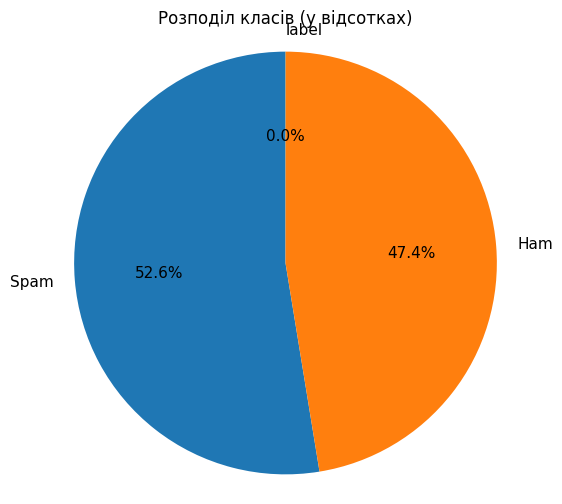

In [4]:
import matplotlib.pyplot as plt

# Якщо у вас інші назви колонки міток — змініть 'label' на потрібну
label_col = 'label'

# Рахуємо відсотковий розподіл
pct = df[label_col].value_counts(normalize=True) * 100

# За бажанням — зробимо підписи більш читабельними для бінарного кейсу
name_map = {'1': 'Spam', '0': 'Ham'}
labels = [name_map.get(k, str(k)) for k in pct.index]

# Побудова діаграми
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    pct.values,
    labels=labels,
    autopct=lambda v: f'{v:.1f}%',
    startangle=90,
    textprops={'color': 'black', 'fontsize': 11},
)
ax.set_title('Розподіл класів (у відсотках)')
ax.axis('equal')  # робить коло круглим
plt.show()


# Створюємо базу спаму, хаму та тестових емейлів

In [5]:
spam_emails = get_spam(df)
ham_emails = get_ham(df)
train_emails = get_train_emails(df)
train_emails[train_emails["label"]=="spam"].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kozak_mamay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kozak_mamay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kozak_mamay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/9f/3qm3m8k90w108hgmspdbjnph0000gn/T/ipykernel_9517/1371138348.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text"] = corpus
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kozak_mamay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading pack

,label,text
7343,spam,x escapelong p escapenumbermg low escapenumber...
7345,spam,offer philippe today interested find breitling...
7347,spam,x drugsplace cialis p prozac soma g levitra it...
7348,spam,like cialis cannot hour right yet imagine viag...
7350,spam,x mahalo offer style safebet www billy thanks ...


# Функція класифікації наївного Байєса

In [6]:
from util import coroutine

def get_word_occurances_in_train_emails(word: str, train_emails: pd.DataFrame) -> int:
    return train_emails["text"].str.count(word).sum()

def get_word_probability(word: str, train_emails: pd.DataFrame) -> float:
    return (get_word_occurances_in_train_emails(word, train_emails) + 1) / (train_emails.shape[0] + 2)

def get_all_words_probabilities(words: np.ndarray, train_emails: pd.DataFrame) -> dict[str, float]:
    return {k: get_word_probability(k, train_emails) for k in words}

def get_probability(dest_size: int, another_size:int) -> float:
    return dest_size / (another_size + dest_size)

def tokenize_test_email(test_email: str, spam_words: np.ndarray, ham_words: np.ndarray) -> np.ndarray:
    test_tokens = set(test_email.split())
    vocab = set(spam_words).union(set(ham_words))
    filtered = test_tokens.intersection(vocab)
    return np.array(list(filtered))

def mul(list_: np.ndarray) -> float:
    return np.nanprod(list_, dtype=np.float64)

@coroutine
def naive_bayes_classification(spam_train_emails: pd.DataFrame, ham_train_emails: pd.DataFrame):
    spam_words = extract_words_from_pd(spam_train_emails)
    ham_words = extract_words_from_pd(ham_train_emails)
    spam_words_probabilities = get_all_words_probabilities(spam_words, spam_train_emails)
    ham_words_probability = get_all_words_probabilities(ham_words, ham_train_emails)
    total_spam = spam_train_emails.shape[0]
    total_ham = ham_train_emails.shape[0]

    # Захист від порожніх класів
    if total_spam == 0 or total_ham == 0:
        raise ValueError("Порожній тренувальний клас: перевірте формування spam/ham вибірок")

    spam_probability = get_probability(total_spam, total_ham)
    ham_probability = get_probability(total_ham, total_spam)

    def word_weight(word: str, weighted_words: dict[str, float], total_class: float) -> float:
        try:
            return weighted_words[word]
        except KeyError:
            # Уникаємо 1/0
            return 1.0 / (total_class + 2.0)

    while True:
        test_email = (yield)

        tokenized_test_email = tokenize_test_email(test_email, spam_words, ham_words)

        probs_s = []
        probs_h = []

        for word in tokenized_test_email:
            probs_s.append(word_weight(word, spam_words_probabilities, total_spam))
            probs_h.append(word_weight(word, ham_words_probability, total_ham))

        p_ws = mul(np.array(probs_s, dtype=np.float64))  # P(W|S)
        p_wh = mul(np.array(probs_h, dtype=np.float64))  # P(W|H)

        denom = p_ws * spam_probability + p_wh * ham_probability
        result = (p_ws * spam_probability) / denom if denom != 0 else float("nan")

        yield result


# Застосуємо формулу наївного Байєса до наших тренувальних сетів

In [7]:
classifier = naive_bayes_classification(spam_emails, ham_emails)

def test_email_for_spamicity(test_email: str):
    try:
        result = float(classifier.send(test_email))
        print(f"Спамність емейла: {result:.2f}")
        if result >= 0.5:
            print(20*"=")
            print("Наступний емейл є спамом")
            print(20*"=")
            print(test_email)
            print(20*"=")
        else:
            print(20*"=")
            print("Наступний емейл є важливим повідомленням")
            print(20*"=")
            print(test_email)
            print(20*"=")
    except (TypeError, ValueError) as e:
        print(20*"=")
        print(f"Спамовості повідомлення не існує. Помилка: {e}")
        print(20*"=")
        print(test_email)
        print(20*"=")

print( 20*"=", "\nПеревіримо тестові спамові повідомлення\n", 20*"=")
for text in train_emails[train_emails["label"] == "spam"].head(10)["text"]:
    test_email_for_spamicity(text)

print( 20*"=", "\nПеревіримо тестові ʼважливіʼ повідомлення\n", 20*"=")
for text in train_emails[train_emails["label"] == "ham"].head(10)["text"]:
    test_email_for_spamicity(text)

Перевіримо тестові спамові повідомлення
Спамність емейла: 1.00
Наступний емейл є спамом
x escapelong p escapenumbermg low escapenumber illescapenumber http per feeldistant forget pill pillescapenumber fake hk mdaabk price er cialisescapenumber escapenumberonly
Спамовості повідомлення не існує. Помилка: float() argument must be a string or a real number, not 'NoneType'
offer philippe today interested find breitling look muller great hi frank cartier intention mechanizim decide remove omega domain place watch quality rolex replica one story many patek cheap
Спамність емейла: 1.00
Наступний емейл є спамом
x drugsplace cialis p prozac soma g levitra item escapenumbermg mg escapenumber lls escapenumberm pe tab jelly http per pill pi e ite ur ultram ave soft hk em sav yo save r ill itemyour viagra lipitor
Спамовості повідомлення не існує. Помилка: float() argument must be a string or a real number, not 'NoneType'
like cialis cannot hour right yet imagine viagra even advantage great want coun